# Fairness in Machine Learning with Fairlearn

## 1. Install and Import Required Libraries

If running locally, uncomment the next line:
!pip install fairlearn scikit-learn matplotlib pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

In [2]:
## 2. Load and Explore the Dataset

# We'll use the 'Adult' dataset, a common fairness benchmark
data = fetch_openml(data_id=1590, as_frame=True)  # 'adult' dataset
df = data.frame

# Preview the data
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
## 3. Preprocess Data

# Select features and sensitive attribute
X = df[['age', 'education-num', 'hours-per-week']]
y = (df['class'] == '>50K').astype(int)  # 1 if income >50K, else 0
A = df['sex']  # Sensitive feature

# Split data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.3, random_state=42, stratify=y
)


In [4]:
## 4. Train a Baseline Model

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7918514979867604


In [5]:
## 5. Evaluate Fairness Metrics

# Use Fairlearn's MetricFrame to compute metrics by group
mf = MetricFrame(
    metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test
)

print("Metric by group:\n", mf.by_group)

# Demographic parity difference (should be close to 0 for fairness)
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)
print("Demographic Parity Difference:", dp_diff)

# Equalized odds difference (should be close to 0 for fairness)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=A_test)
print("Equalized Odds Difference:", eo_diff)

Metric by group:
         accuracy  selection_rate
sex                             
Female  0.872555        0.077826
Male    0.751837        0.139853
Demographic Parity Difference: 0.06202718281856606
Equalized Odds Difference: 0.03825453503318105


In [7]:
## 6. Mitigate Bias Using Fairlearn

# Apply Exponentiated Gradient with Demographic Parity constraint
mitigator = ExponentiatedGradient(
    LogisticRegression(solver='liblinear'),
    constraints=DemographicParity()
)
mitigator.fit(X_train, y_train, sensitive_features=A_train)
y_pred_mitigated = mitigator.predict(X_test)

# Evaluate mitigated model
mf_mitigated = MetricFrame(
    metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=A_test
)
print("Mitigated Metric by group:\n", mf_mitigated.by_group)

dp_diff_mitigated = demographic_parity_difference(y_test, y_pred_mitigated, sensitive_features=A_test)
print("Mitigated Demographic Parity Difference:", dp_diff_mitigated)

eo_diff_mitigated = equalized_odds_difference(y_test, y_pred_mitigated, sensitive_features=A_test)
print("Mitigated Equalized Odds Difference:", eo_diff_mitigated)

Mitigated Metric by group:
         accuracy  selection_rate
sex                             
Female  0.877496        0.036236
Male    0.718354        0.050633
Mitigated Demographic Parity Difference: 0.014396551499467038
Mitigated Equalized Odds Difference: 0.00432698166390999


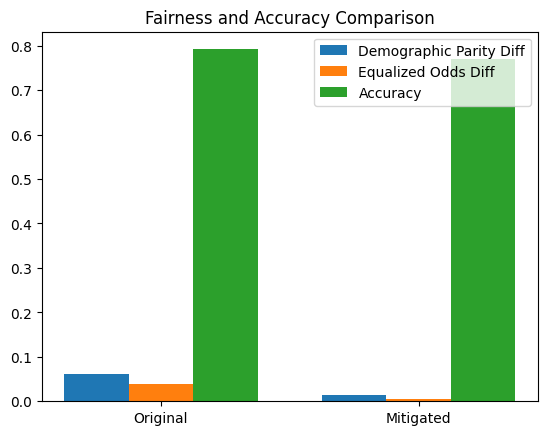

In [9]:
## 7. Visualize Fairness Tradeoffs

labels = ['Original', 'Mitigated']
dp = [dp_diff, dp_diff_mitigated]
eo = [eo_diff, eo_diff_mitigated]
acc = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_mitigated)]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, dp, width, label='Demographic Parity Diff')
ax.bar(x, eo, width, label='Equalized Odds Diff')
ax.bar(x + width, acc, width, label='Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.title("Fairness and Accuracy Comparison")

# save the image
plt.savefig('public/fairness_accuracy_comparison.png')

In [12]:
# Using AI to interpret the result
from google.genai import types
from google import genai
from dotenv import load_dotenv
import os
from IPython.display import display, Markdown

load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=gemini_api_key)

# list all models
print("List of models that support generateContent:\n")
for m in client.models.list():
    for action in m.supported_actions:
        if action == "generateContent":
            print(m.name)

List of models that support generateContent:

models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemin

In [13]:
model = [
    "gemini-2.5-flash-preview-04-17-thinking"
]

with open('public/fairness_accuracy_comparison.png', 'rb') as image_file:
    image = image_file.read()

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=image,
            mime_type='image/png',
        ),
        "What do you think about the fairness and accuracy comparison of the original and mitigated models? What are the trade-offs?",
    ]
)

display(Markdown(response.text))

Based on the bar chart comparing the "Original" and "Mitigated" models:

1.  **Original Model:**
    *   Shows high accuracy (around 0.8).
    *   Exhibits relatively poor fairness, with noticeable differences in Demographic Parity (around 0.06) and Equalized Odds (around 0.03-0.04). The higher these differences, the less fair the model is according to these metrics.

2.  **Mitigated Model:**
    *   Shows significantly improved fairness, with the Demographic Parity Diff dropping close to zero (below 0.01) and the Equalized Odds Diff also dropping close to zero (below 0.01). This indicates the mitigation process was highly effective in reducing disparities across groups based on these metrics.
    *   Maintains high accuracy, though slightly lower than the original model (around 0.78-0.79).

**Trade-offs:**

The chart clearly illustrates a common trade-off in algorithmic fairness:

*   **Improved Fairness vs. Slightly Reduced Accuracy:** The mitigation process successfully and significantly reduced the disparities measured by Demographic Parity and Equalized Odds differences. However, this improvement in fairness came at a small cost to overall model accuracy. The accuracy dropped slightly when moving from the original to the mitigated model.

In summary, the mitigation technique applied achieved a substantial improvement in fairness according to both Demographic Parity and Equalized Odds metrics, while successfully retaining most, but not all, of the original model's accuracy. The trade-off was a slight decrease in accuracy for a significant gain in fairness.

## 8. Conclusion

This notebook demonstrated how to:
- Assess fairness of a model using Fairlearn
- Apply bias mitigation
- Compare fairness and accuracy before and after mitigation
- Interpretation of results using state-of-the-art vision thinking generative AI

For more, see: https://fairlearn.org/